In [3]:
import sys
sys.path.insert(0, "../..")

import jax
import jax.numpy as jnp
from jax import jvp, vjp

import jax.scipy
import jax.scipy.special

from tqdm import tqdm
from functools import partial

import module.samplers
import module.hamiltonians
import module.wavefunctions

import flax.linen as nn

import optax
import numpy as np
from matplotlib import pyplot as plt

In [4]:
key = jax.random.PRNGKey(0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
def getLine(phi, theta, r_max = 10):
    r = jnp.linspace(-r_max, r_max, num = 2000)
    x = jnp.cos(phi)*jnp.sin(theta) * r
    y = jnp.sin(phi)*jnp.sin(theta) * r
    z = jnp.cos(theta) * r

    return r, jnp.stack((x,y,z), axis = 1)

## 1. Introduction

In this notebook, we try to demonstrate an LCAO Ansatz combined with a Neural Network to find the ground state of the $\mathrm{H}_2^{+}$ molecule.
The LCAO Ansatz enforces the Kato-cusp condition, which is difficult to model by a Neural Network (singularity of the gradient). The deviations from the LCAO Ansatz are represented by a Neural Network.

Given the nucliei positions $\vec{R_i} $, the potential Energy is:

$$
V = - \sum_{i} \frac{k_i}{|\vec{r} - \vec{R_i}|}
$$

with $k_i = \frac{Z_i e^2}{4 \pi \epsilon_0}$

The solution to the single-nucleus problem is known:

$$
\Phi_i = e^{-\frac{m}{\hbar^2}k_i |\vec{r} - \vec{R_i}|} 
$$

notably satisfying the cusp condition:

$$
Z_k = -\frac{a_0}{2 n} \frac{dn}{dr} \quad\text{for} \lim r \to 0
$$

with $n = |\Psi|^2$.

The resulting Ansatz is thus:

$$
\Psi = \sum_{i} \alpha_i \Phi_i(\vec{r}) + e^{NN(\vec{r})}
$$

and $NN$ is a $C^2$-smooth Neural Network.

Remark: $\hbar = m  = 1$ and $k = \sqrt{2}$ will be set.

### 1.1 Defining the Potential Energy

(-5.0, 1.0)

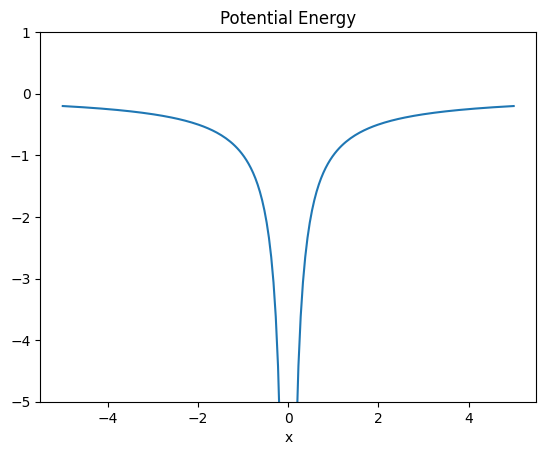

In [58]:
R = jnp.array([[0.,0.,0.]])     # nuclei positions
k = jnp.array([1.])                          # potential energy coefficients

#
# The potential energy function depending on the coordinates
#
def potential(x, param):
    x = jnp.expand_dims(x, axis = 1)
    r = jnp.expand_dims(R,  axis = 0)
    d = jnp.sqrt(jnp.sum((x - r)**2, axis = 2))
    return - jnp.sum(k/d ,axis = 1)


# the hamiltonian
hamiltonian = module.hamiltonians.Particles(masses = [1], potential = potential)

xs = jnp.linspace(-5, 5, 200)
pos = jnp.array([xs,xs*0,xs*0])
ys = potential(jnp.swapaxes(pos, 0, 1), 0)
plt.plot(xs, ys)
plt.title("Potential Energy")
plt.xlabel("x")
plt.ylim(-5, 1)

### 1.2 Defining the Wavefunction

In [59]:
class NN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(15, name="dense1", bias_init=jax.random.normal)(x)
        x = jnp.log(jnp.cosh(x))
        x = nn.Dense(15, name="dense2", bias_init=jax.random.normal)(x)
        x = jnp.log(jnp.cosh(x))
        x = nn.Dense(15, name="dense3", bias_init=jax.random.normal)(x)
        x = jnp.log(jnp.cosh(x))
        x = nn.Dense(1, name="dense4", bias_init=jax.random.normal)(x)
        x = jnp.log(jnp.cosh(x))
        return -jnp.squeeze(x)

In [60]:
class Ansatz(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__(input_shape = (3,))

        self.nn = NN()
        self.lcao = module.wavefunctions.LCAO()


    def init_param(self, key):
        nn_param = self.nn.init(key, jnp.empty((3,)))
        lcao_coeff = self.lcao.init_parameters(R, k, lamb=jnp.array(1.))

        return {"nn": nn_param,
                "lcao": lcao_coeff}
    
    def calc_logpsi(self, parameters, x):
        return self.lcao.calc_logpsi(parameters["lcao"], x) + self.nn.apply(parameters["nn"], x)

In [61]:
ansatz = Ansatz()
key, _ = jax.random.split(key)
param = ansatz.init_param(key)

Text(0.5, 0, 'x')

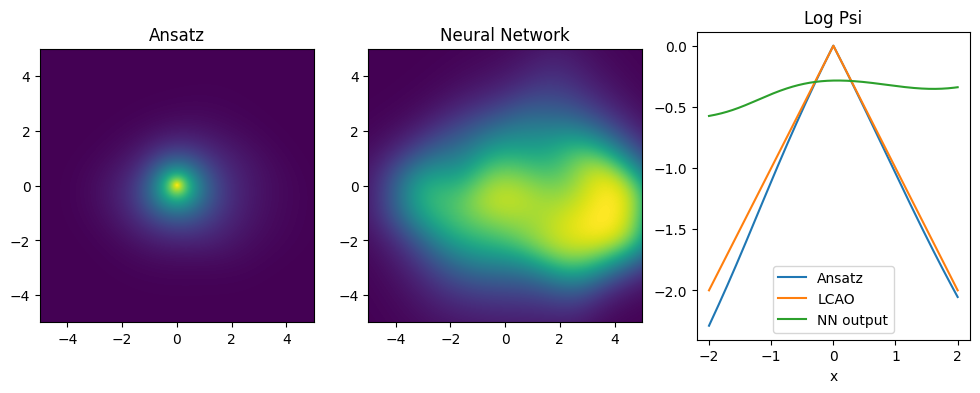

In [62]:
f, axs = plt.subplots(1, 3, figsize = (12,4))

xs = jnp.linspace(-5, 5, num = 1000)
ys = jnp.linspace(-5, 5, num = 1000)
xss, yss = jnp.meshgrid(xs, ys)
im = jnp.stack((xss, yss, jnp.ones_like(xss) * 0), axis = 2)

res = ansatz.calc_psi(param, im.reshape(-1, 3)).reshape(xss.shape)
axs[0].imshow(res, extent = [-5, 5, -5, 5])
axs[0].set_title("Ansatz")

res = ansatz.nn.apply(param["nn"], im.reshape(-1, 3)).reshape(xss.shape)
axs[1].imshow(jnp.exp(res), extent = [-5, 5, -5, 5])
axs[1].set_title("Neural Network")


r, line = getLine(0, jnp.pi/2, r_max=2)
psi = ansatz.calc_logpsi(param, line)
psi_lcao = ansatz.lcao.calc_logpsi(param["lcao"], line)
nn_out = ansatz.nn.apply(param["nn"], line)

axs[2].plot(r, psi - jnp.max(psi), label = "Ansatz")
axs[2].plot(r, psi_lcao - jnp.max(psi_lcao), label = "LCAO")
axs[2].plot(r, nn_out, label = "NN output")

axs[2].set_title("Log Psi")
axs[2].legend()
axs[2].set_xlabel("x")

### 1.3 Initialise Sampler

In [63]:
sampler = module.samplers.MCMCsimple(ansatz, 0.5)

Acceptance Ratio: 0.48479998
Expected Energy: -0.44860178
Std of Expected Energy: 0.0023692034


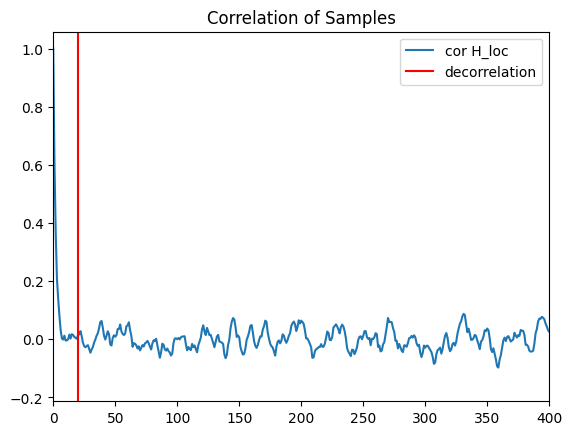

In [64]:
N = 10000
samples, ratio = sampler.sample(key, param, jax.random.normal(key, shape = (3,)), N)
H_loc = hamiltonian.calc_H_loc(ansatz, param, samples)
print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc))
print("Std of Expected Energy:", jnp.std(H_loc)/jnp.sqrt(N))

plt.plot(jnp.correlate(H_loc-jnp.mean(H_loc), H_loc[0:2000]-jnp.mean(H_loc))/jnp.std(H_loc[0:2000])**2/2000, label = "cor H_loc")
plt.xlim(0,400)
plt.axvline(20, color = "r", label = "decorrelation")
plt.title("Correlation of Samples")
plt.legend()
plt.show()

In [65]:
subsampling = 20

In [66]:
def get_samples(N):
    """
    Returns decorrelated samples.
    """
    samples, ratio = sampler.sample(key, param, jax.random.normal(key, shape = (3,)), N*subsampling)
    return samples[0:-1:subsampling], ratio

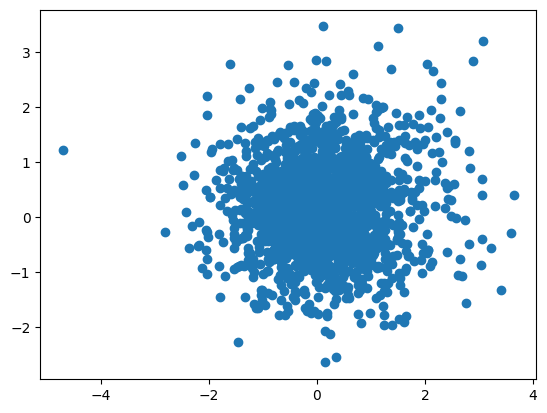

In [67]:
samples, ratio = get_samples(2000)
plt.scatter(samples[:, 0], samples[:, 1])

## 2. Energy Minimisation

In [85]:
@partial(jax.jit, static_argnames=['hamiltonian', 'orbital'])
def calc_grad_E(hamiltonian, orbital, parameters, samples):
    """
    Calculates the gradient of the energy and the energy itself on a batch of samples.
    """

    E_loc = hamiltonian.calc_H_loc(orbital, parameters, samples)
    E = jnp.mean(E_loc)
    dE = jnp.std(E_loc)

    logpsi_red = lambda parameters: orbital.calc_logpsi(parameters, samples)
    y, v = vjp(logpsi_red, parameters)
    N = samples.shape[0]

    m = lambda tree: 2*jnp.real(tree/N)

    return jax.tree_util.tree_map(m, v(E_loc - E))[0], E, dE

In [86]:
stats = {"E":[], "dE":[], "ratio":[]}
param = ansatz.init_param(key)

In [87]:
optimizer = optax.adam(0.001)
optimizer_state = optimizer.init(param["nn"])

In [93]:
N = 4000
epoch = 100

for i in tqdm(range(epoch)):
    key, _ = jax.random.split(key)
    samples, ratio = get_samples(N)
    grad, E, dE = calc_grad_E(hamiltonian, ansatz, param, samples)

    stats["E"].append(E)
    stats["dE"].append(dE)
    stats["ratio"].append(ratio)
    
    updates, optimizer_state = optimizer.update(grad["nn"], optimizer_state, param["nn"])

    param["nn"] = optax.apply_updates(param["nn"], updates)

100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


Text(0.5, 1.0, 'Acceptance Ratio')

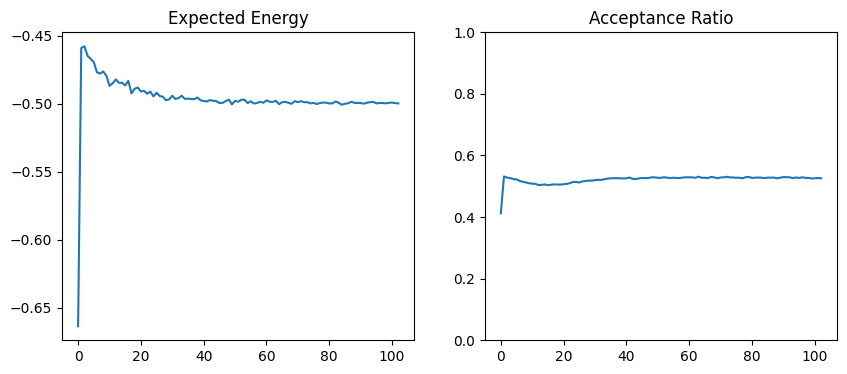

In [94]:
numpy_stats = {}
for key_ in stats.keys():
    numpy_stats[key_] = np.array(stats[key_])

f, ax = plt.subplots(1, 2, figsize = (10,4))
i = np.arange(len(stats["E"]))

ax[0].plot(i, numpy_stats["E"])
# ax[0].fill_between(i, numpy_stats["E"] - numpy_stats["dE"], numpy_stats["E"] + numpy_stats["dE"], alpha = 0.5)
ax[0].set_title("Expected Energy")

ax[1].plot(stats["ratio"])
ax[1].set_ylim(0,1)
ax[1].set_title("Acceptance Ratio")

Text(0.5, 1.0, 'Neural Network')

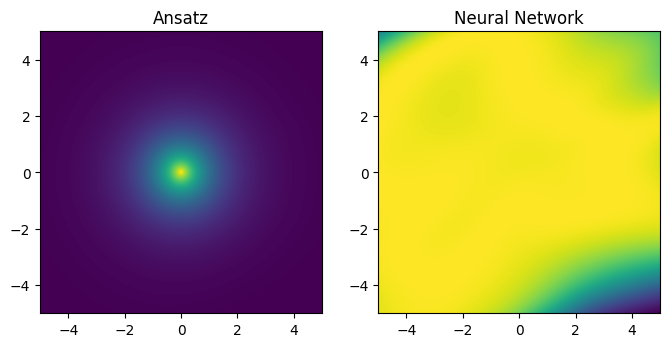

In [95]:
f, axs = plt.subplots(1, 2, figsize = (8,4))

xs = jnp.linspace(-5, 5, num = 1000)
ys = jnp.linspace(-5, 5, num = 1000)
xss, yss = jnp.meshgrid(xs, ys)
im = jnp.stack((xss, yss, jnp.ones_like(xss) * 0), axis = 2)

res = ansatz.calc_psi(param, im.reshape(-1, 3)).reshape(xss.shape)
axs[0].imshow(res, extent = [-5, 5, -5, 5])
axs[0].set_title("Ansatz")

res = ansatz.nn.apply(param["nn"], im.reshape(-1, 3)).reshape(xss.shape)
axs[1].imshow(jnp.exp(res), extent = [-5, 5, -5, 5])
axs[1].set_title("Neural Network")

Text(0.5, 0, 'x')

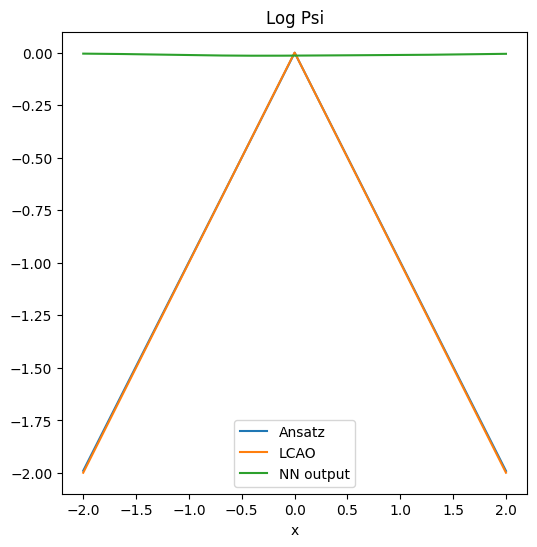

In [96]:
plt.figure(figsize=(6, 6))

r, line = getLine(0, jnp.pi/2, r_max=2)
psi = ansatz.calc_logpsi(param, line)
psi_lcao = ansatz.lcao.calc_logpsi(param["lcao"], line)
nn_out = ansatz.nn.apply(param["nn"], line)

plt.plot(r, psi - jnp.max(psi), label = "Ansatz")
plt.plot(r, psi_lcao - jnp.max(psi_lcao), label = "LCAO")
plt.plot(r, nn_out, label = "NN output")


plt.title("Log Psi")
plt.legend()
plt.xlabel("x")

In [97]:
N = 10000
samples, ratio = get_samples(N)
H_loc = hamiltonian.calc_H_loc(ansatz, param, samples)
print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc))
print("Std of Expected Energy:", jnp.std(H_loc)/jnp.sqrt(N))

Acceptance Ratio: 0.526255
Expected Energy: -0.49939653
Std of Expected Energy: 0.00020368042
